In [20]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image
import matplotlib.pylab as plt
import torch.optim as optim
from torch.autograd import Variable

In [21]:
# config device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [30]:
# Define your hyperparameters (5 points)
latent_size = 128
hidden_size = 256
image_size = 784
num_epochs = 50
batch_size = 64
lr = 0.0002

In [31]:
sample_dir = "gan_sample"
if not os.path.exists(sample_dir):
  os.makedirs(sample_dir)

# Image processing
transform = transforms.Compose([
                transforms.ToTensor()
            ])

# MNIST dataset
mnist = torchvision.datasets.MNIST(root='./data/',
                                   train=True,
                                   transform=transform,
                                   download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(mnist, batch_size=batch_size, shuffle=True)

In [32]:
#Utility Functions
def denorm(x):
  out = (x+1)/2
  return out.clamp(0,1) # normalize the data into the range between 0 and 1.

def reset_grad():
  d_optimizer.zero_grad()
  g_optimizer.zero_grad()

In [33]:
# define the discriminator
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid()
)

# define the generator
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh()
)

D = D.to(device)
G = G.to(device)

In [34]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=lr)
g_optimizer = torch.optim.Adam(G.parameters(), lr=lr)

In [35]:
# Start training GAN (10 points)
total_step = len(data_loader.dataset)
losses_d = []
losses_g = []
scores_d = []
scores_g = []
for epoch in range(num_epochs):
  total_d_loss, total_g_loss = 0,0
  d_score, g_score = 0, 0
  for i, (images, _) in enumerate(data_loader):
      images = images.view(-1, image_size).to(device)
      images = Variable(images)
      n = images.shape[0]
      # Create the labels which are later used as input
      real_labels = Variable(torch.ones((n,1)).to(device), requires_grad=False)
      fake_labels = Variable(torch.zeros((n,1)).to(device), requires_grad=False)

      ### 1. Discriminator Training starts (5 points)###

      # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
      # Second term of the loss is always zero since real_labels == 1
      outputs = D(images)
      d_loss_real = criterion(outputs, real_labels)
      # d_loss_real = -torch.mean(torch.log(outputs))
      preds = (outputs >= 0.5) * 1
      real_score = torch.sum(real_labels == preds).item()
      
      # Compute BCELoss using fake images
      # First term of the loss is always zero since fake_labels == 0
      z = Variable(torch.randn(n, latent_size).to(device))
      fake_images = G(z)
      outputs = D(fake_images)
      d_loss_fake = criterion(outputs, fake_labels)
      # d_loss_fake = -torch.mean(torch.log(1 - outputs))
      preds = (outputs >= 0.5) * 1
      fake_score = torch.sum(fake_labels == preds).item()
      # Backprop and optimize
      #Your Code#
      d_loss = (d_loss_real + d_loss_fake) / 2
      reset_grad()
      d_loss.backward()
      d_optimizer.step()
      d_score += (real_score + fake_score) / 2
      
      ### 2. Generator Training starts (5 points)###

      # Compute loss with fake images
      z = Variable(torch.randn(n, latent_size).to(device))
      fake_images = G(z)
      outputs = D(fake_images)
      # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
      g_loss = criterion(outputs, real_labels)
      # g_loss = -torch.mean(torch.log(outputs))
      # Backprop and optimize
      #Your Code#
      reset_grad()
      g_loss.backward()
      g_optimizer.step()
      preds = (outputs >= 0.5) * 1
      g_score += torch.sum(real_labels == preds).item()

      total_g_loss += g_loss.item() * n
      total_d_loss += d_loss.item() * n 
  total_d_loss /= total_step
  total_g_loss /= total_step

  # Print out your loss, score for both of your discriminator and generator per epoch
  if (epoch+1) % 10 == 0:
    print('Epoch: %d \t D Loss: %.4f \t G Loss: %.4f \t D score: %.4f \t G score: %.4f' % (epoch+1, total_d_loss, total_g_loss, d_score / total_step, g_score/total_step))
  losses_g.append(total_g_loss)
  losses_d.append(total_d_loss)
  scores_d.append(d_score / total_step)
  scores_g.append(g_score / total_step)
  # Save real images
  if (epoch+1) == 1:
      images = images.view(-1, 1, 28, 28)
      save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))
  
  # Save sampled images
  fake_images = fake_images.view(-1, 1, 28, 28)
  save_image(denorm(fake_images), os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))

Epoch: 10 	 D Loss: 0.0892 	 G Loss: 5.5290 	 D score: 0.9701 	 G score: 0.0048
Epoch: 20 	 D Loss: 0.0647 	 G Loss: 6.1298 	 D score: 0.9780 	 G score: 0.0059
Epoch: 30 	 D Loss: 0.0605 	 G Loss: 6.3276 	 D score: 0.9793 	 G score: 0.0069
Epoch: 40 	 D Loss: 0.0689 	 G Loss: 6.1000 	 D score: 0.9752 	 G score: 0.0094
Epoch: 50 	 D Loss: 0.0928 	 G Loss: 5.4651 	 D score: 0.9660 	 G score: 0.0153


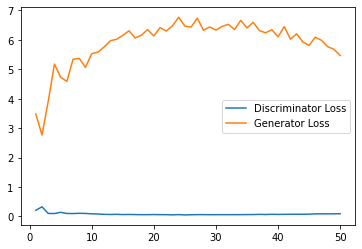

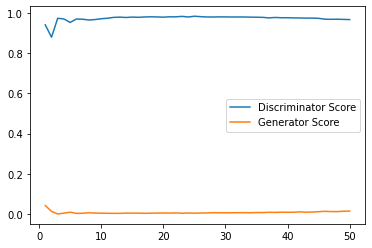

In [36]:
ep = range(1, num_epochs+1)
plt.plot(ep, losses_d, label='Discriminator Loss')
plt.plot(ep, losses_g, label='Generator Loss')
plt.legend()
plt.show()
plt.plot(ep, scores_d, label='Discriminator Score')
plt.plot(ep, scores_g, label='Generator Score')
plt.legend()
plt.show()

Real images:


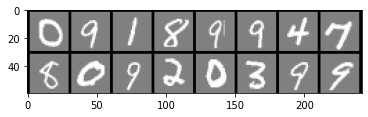

Fake images:


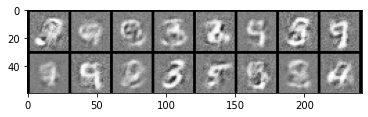

In [37]:
# Visualize first 5 image from the real images and fake images
# and compare them to see whether they are similar (5 points)

from matplotlib import image

sample_dir = "gan_sample"
real = image.imread(os.path.join(sample_dir, 'real_images.png'))
fake = image.imread(os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))
print('Real images:')
plt.imshow(real[:60,:280])
plt.show()
print('Fake images:')
plt.imshow(fake[:60,:280])
plt.show()